In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# File name: sess_num_dependent_scale_factor.py
"""
Created on Wed Jun 27 21:34:09 2018

@author: Neo(liuniu@smail.nju.edu.cn)
"""

import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, deg2rad, sqrt
from scipy.optimize import curve_fit
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from error_inflation_progs import (error_inflation, sf_nf_calc, wrms_calc)

In [2]:
def sess_dependent_sf(num_sort, dRAc, dDec, dRAc_err, dDec_err, interv_size=50):
    """Calculate the scale factor as the number of session changes.

    Parameters
    ----------
    num_sort : array_like of int
        number of sessions/observations a source was observed
    dRAc/dDec : array_like of float type
        offset in right ascension/declination component in mas
    dRAc_err/dDec_err : array_like of float type
        formal uncertainty of dRAc/dDec in mas
    interv_size : int
        number of source in an interval

    Returns
    ----------
    sf_ra/sf_dec : array of float
        scale factor in right ascension/declination component
    num_min : array of int
        minimum number of session/observation in the subset
    """

    if num_sort.size <= interv_size:
        print("# Too smaller sample!")
        exit()
    else:
        interv_num = num_sort.size - interv_size + 1

    sf_RAc = np.ones(interv_num)
    sf_Dec = np.ones(interv_num)
    num_min = np.ones(interv_num)

    for i in range(interv_num):
        ind_b, ind_e = i, i + interv_size
        num_sorts = num_sort[ind_b: ind_e]
        dRAc_s = dRAc[ind_b: ind_e]
        dRAc_errs = dRAc_err[ind_b: ind_e]
        dDec_s = dDec[ind_b: ind_e]
        dDec_errs = dDec_err[ind_b: ind_e]
        
        num_min[i] = np.median(num_sorts)
        
        # Calculate their standard deviation (scale factor)
        sf_RAc[i] = np.std(dRAc_s / dRAc_errs)
        sf_Dec[i] = np.std(dDec_s / dDec_errs)

    return num_min, sf_RAc, sf_Dec

In [3]:
# Load data
datfile = ("../logs/pos_diff_cln.dat")
soulist = np.genfromtxt(datfile, usecols=(0,), dtype=str)
RA, Dec, dRAc, dDec, dRAc_err, dDec_err = np.genfromtxt(
    datfile, usecols=range(1, 7), unpack=True)
num_ses_mean = np.genfromtxt(datfile, dtype=int, usecols=(10,))

num_ses_mean = num_ses_mean * 2

# Load results of scale factor and noise floor
lab = np.genfromtxt("../logs/nf_sf.dat", usecols=(0,), dtype=str)
sf_RA, nf_RA, sf_Dec, nf_Dec = np.genfromtxt(
    "../logs/nf_sf.dat", usecols=(1, 3, 5, 7), unpack=True)

In [4]:
# Sort the data according to the number of sessions/observations
ind = np.argsort(num_ses_mean)
num_ses_sort = np.take(num_ses_mean, ind)
dRAc_sort = np.take(dRAc, ind)
dDec_sort = np.take(dDec, ind)
dRAc_err_sort = np.take(dRAc_err, ind)
dDec_err_sort = np.take(dDec_err, ind)

# Calculate the original scale factor as the running move windows over number of sessions
num_min0, sf_RAc0, sf_Dec0 = sess_dependent_sf(
    num_ses_sort, dRAc_sort, dDec_sort, dRAc_err_sort, dDec_err_sort, interv_size=50)

In [5]:
# Inflate the formal error
# ----------------
# Result of DSM
dRAc_err_inf = error_inflation(dRAc_err_sort, sf_RA[0], nf_RA[0])
dDec_err_inf = error_inflation(dDec_err_sort, sf_Dec[0], nf_Dec[0])

# dRAc_err_inf = error_inflation(dRAc_err_sort, sf_RA[0], 0)
# dDec_err_inf = error_inflation(dDec_err_sort, sf_Dec[0], 0)

# Calculate the post-inflation scale factor as the running move windows over number of sessions
num_min1, sf_RAc1, sf_Dec1 = sess_dependent_sf(
    num_ses_sort, dRAc_sort, dDec_sort, dRAc_err_inf, dDec_err_inf, interv_size=50)

# ----------------
# Result of SBL
dRAc_err_inf = error_inflation(dRAc_err_sort, sf_RA[1], nf_RA[1])
dDec_err_inf = error_inflation(dDec_err_sort, sf_Dec[1], nf_Dec[1])

# dRAc_err_inf = error_inflation(dRAc_err_sort, sf_RA[1], 0)
# dDec_err_inf = error_inflation(dDec_err_sort, sf_Dec[1], 0)

# Calculate the post-inflation scale factor as the running move windows over number of sessions
num_min2, sf_RAc2, sf_Dec2 = sess_dependent_sf(
    num_ses_sort, dRAc_sort, dDec_sort, dRAc_err_inf, dDec_err_inf, interv_size=50)

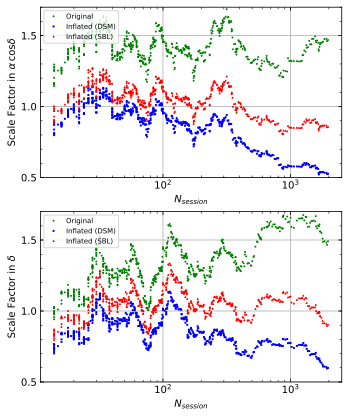

In [8]:
# scale factor VS number of session (plot)
# fig, (ax0, ax1) = plt.subplots(figsize=(10, 4), ncols=2, sharex=True)
fig, (ax0, ax1) = plt.subplots(figsize=(5, 6), nrows=2)

ax0.plot(num_min0, sf_RAc0, "go", markersize=1, label="Original")
ax0.plot(num_min1, sf_RAc1, "bs", markersize=1, label="Inflated (DSM)")
ax0.plot(num_min2, sf_RAc2, "r^", markersize=1, label="Inflated (SBL)")


ax1.plot(num_min0, sf_Dec0, "go", markersize=1, label="Original")
ax1.plot(num_min1, sf_Dec1, "bs", markersize=1, label="Inflated (DSM)")
ax1.plot(num_min2, sf_Dec2, "r^", markersize=1, label="Inflated (SBL)")


ax0.set_xscale("log")
ax0.set_xlabel("$N_{session}$")
ax0.set_ylabel("Scale Factor in $\\alpha\\,\\cos\\delta$")
ax0.xaxis.set_ticks_position('both')
ax0.yaxis.set_ticks_position('both')
# ax0.set_xlim([10, 1100])
ax0.set_yticks(np.arange(0.5, 2.1, 0.5))
ax0.set_ylim([0.5, 1.7])
ax0.grid(True)
# ax0.legend(loc="upper left", fontsize="small")
ax0.legend(loc="upper left", fontsize="x-small")

ax1.set_xscale("log")
ax1.set_xlabel("$N_{session}$")
ax1.set_ylabel("Scale Factor in $\\delta$")
ax1.set_yticks(np.arange(0.5, 2.1, 0.5))
# ax1.set_xlim([10, 1100])
ax1.set_ylim([0.5, 1.7])
ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')
ax1.grid(True)
# ax1.legend(loc="upper left", fontsize="small")
ax1.legend(loc="upper left", fontsize="x-small")

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator = MultipleLocator(0.1)
ax0.yaxis.set_minor_locator(minorLocator)
ax1.yaxis.set_minor_locator(minorLocator)

plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
plt.savefig("../plots/sess_num_sf.eps")

# plt.savefig("/Users/Neo/Desktop/sess_num_sf.png")